In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## In this notebook, we will come up with all the preprocessing 

In this notebook we want to study the gemstone price data set

In [215]:
## Load training data
train_df = pd.read_csv('./Data/train.csv')
train_df = train_df.drop(columns='id')

# We will load the original data since it helps with the predicitoj
original_df = pd.read_csv("./Data/cubic_zirconia.csv")

# Impute data and then merge them
original_df['depth'] = original_df['depth'].fillna(2*original_df['z']/(original_df['x']+original_df['y']))
original_df = original_df.drop(columns='Unnamed: 0')

# concat the two dataframes
train_df = pd.concat([train_df, original_df])

# # We first want to now reset the index
train_df.reset_index(drop=True)

# preprocessing
cut_labeling = {col: val for val, col in enumerate(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])}
color_labeling = {col: val for val, col in enumerate(['J', 'I', 'H', 'G', 'F', 'E', 'D'])}
clarity_labeling = {col: val for val, col in enumerate(
    ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VVS2', 'VVS1', 'VS2', 'VS1', 'IF', 'FL'])}
# to preprocess label features, map label to integer number.
def preprocessing(df):
    df['cut'] = df['cut'].map(cut_labeling)
    df['color'] = df['color'].map(color_labeling)
    df['clarity'] = df['clarity'].map(clarity_labeling)
    return df

# Process data
train_df = preprocessing(train_df)

# We can impute several values, but given that we have 19000 data points, we can just drop those 
for key in ['x', 'y', 'z']:
    train_df = train_df.drop(train_df[train_df[key] == 0].index)


# Create a bunch of new features
def create_features(df):
    # Create new features for learning
    df['volume'] = df['x'] * df['y'] * df['z']  # Volumen of gems
    df['density'] = df['carat'] / df['volume']  # Density of gems
    df['table_percentage'] = (df['table'] / ((df['x'] + df['y']) / 2)) * 100    # The table percentage (of the gem face)
    df['depth_percentage'] = (df['depth'] / ((df['x'] + df['y']) / 2)) * 100    # The depth percentage
    # df['symmetry'] = (abs(df['x'] - df['z']) + abs(df['y'] - df['z'])) / (df['x'] + df['y'] + df['z'])  # Symmetry of the gem
    df['surface_area'] = 2 * ((df['x'] * df['y']) + (df['x'] * df['z']) + (df['y'] * df['z']))  # Surface area of gem
    df['depth_to_table_ratio'] = df['depth'] / df['table']  # ratio

    return df

# Create new features
train_df = create_features(train_df)

# So it makes sense to drop density that are far away from the average
train_df.drop(train_df[(train_df['density'] < 0.004)].index, inplace=True)
train_df.drop(train_df[(train_df['density'] > 0.01)].index, inplace=True)

# Depth to table ration 
train_df.drop(train_df[(train_df['depth_to_table_ratio'] < 0.25)].index, inplace=True)

In [216]:
train_df

,carat,cut,color,clarity,depth,table,x,y,z,price,volume,density,table_percentage,depth_percentage,surface_area,depth_to_table_ratio
0,1.52,3,4,7,62.2,58.0,7.27,7.33,4.55,13619,242.465405,0.006269,794.520548,852.054795,239.4382,1.072414
1,2.03,2,0,3,62.0,58.0,8.06,8.12,5.05,13387,330.508360,0.006142,716.934487,766.378245,294.3124,1.068966
2,0.70,4,3,8,61.2,57.0,5.69,5.73,3.50,2772,114.112950,0.006134,998.248687,1071.803853,145.1474,1.073684
3,0.32,4,3,8,61.6,56.0,4.38,4.41,2.71,666,52.345818,0.006113,1274.175199,1401.592719,86.2734,1.100000
4,1.70,3,3,7,62.6,59.0,7.65,7.61,4.77,14453,277.692705,0.006122,773.263434,820.445609,262.0134,1.061017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26962,1.11,3,3,4,62.3,58.0,6.61,6.52,4.09,5408,176.267548,0.006297,883.472963,948.971820,193.5978,1.074138
26963,0.33,4,2,9,61.9,55.0,4.44,4.42,2.74,1114,53.771952,0.006137,1241.534989,1397.291196,87.8024,1.125455
26964,0.51,3,5,7,61.7,58.0,5.12,5.15,3.17,1656,83.586560,0.006101,1129.503408,1201.557936,117.8478,1.063793
26965,0.27,2,4,5,61.8,56.0,4.19,4.20,2.60,682,45.754800,0.005901,1334.922527,1473.182360,78.8240,1.103571


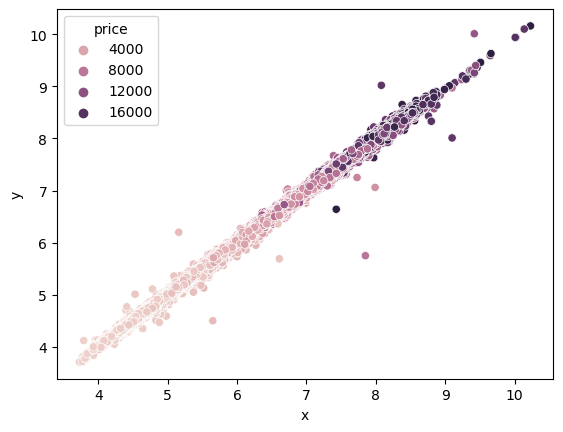

In [217]:
# Make a scatter plot of training data with x and y with price a hue
sns.scatterplot(x='x', y='y', hue='price', data=train_df)

plt.show()

So there are some pretty obvious details 

X: Length of the cubic zirconia in mm.
Y: Width of the cubic zirconia in mm.
Z: Height of the cubic zirconia in mm.

Most importantly, these quantities are all related Depth = 2*Z / (X+Y)

We know there are some 0 values in the data, so we can impute these based on the formula

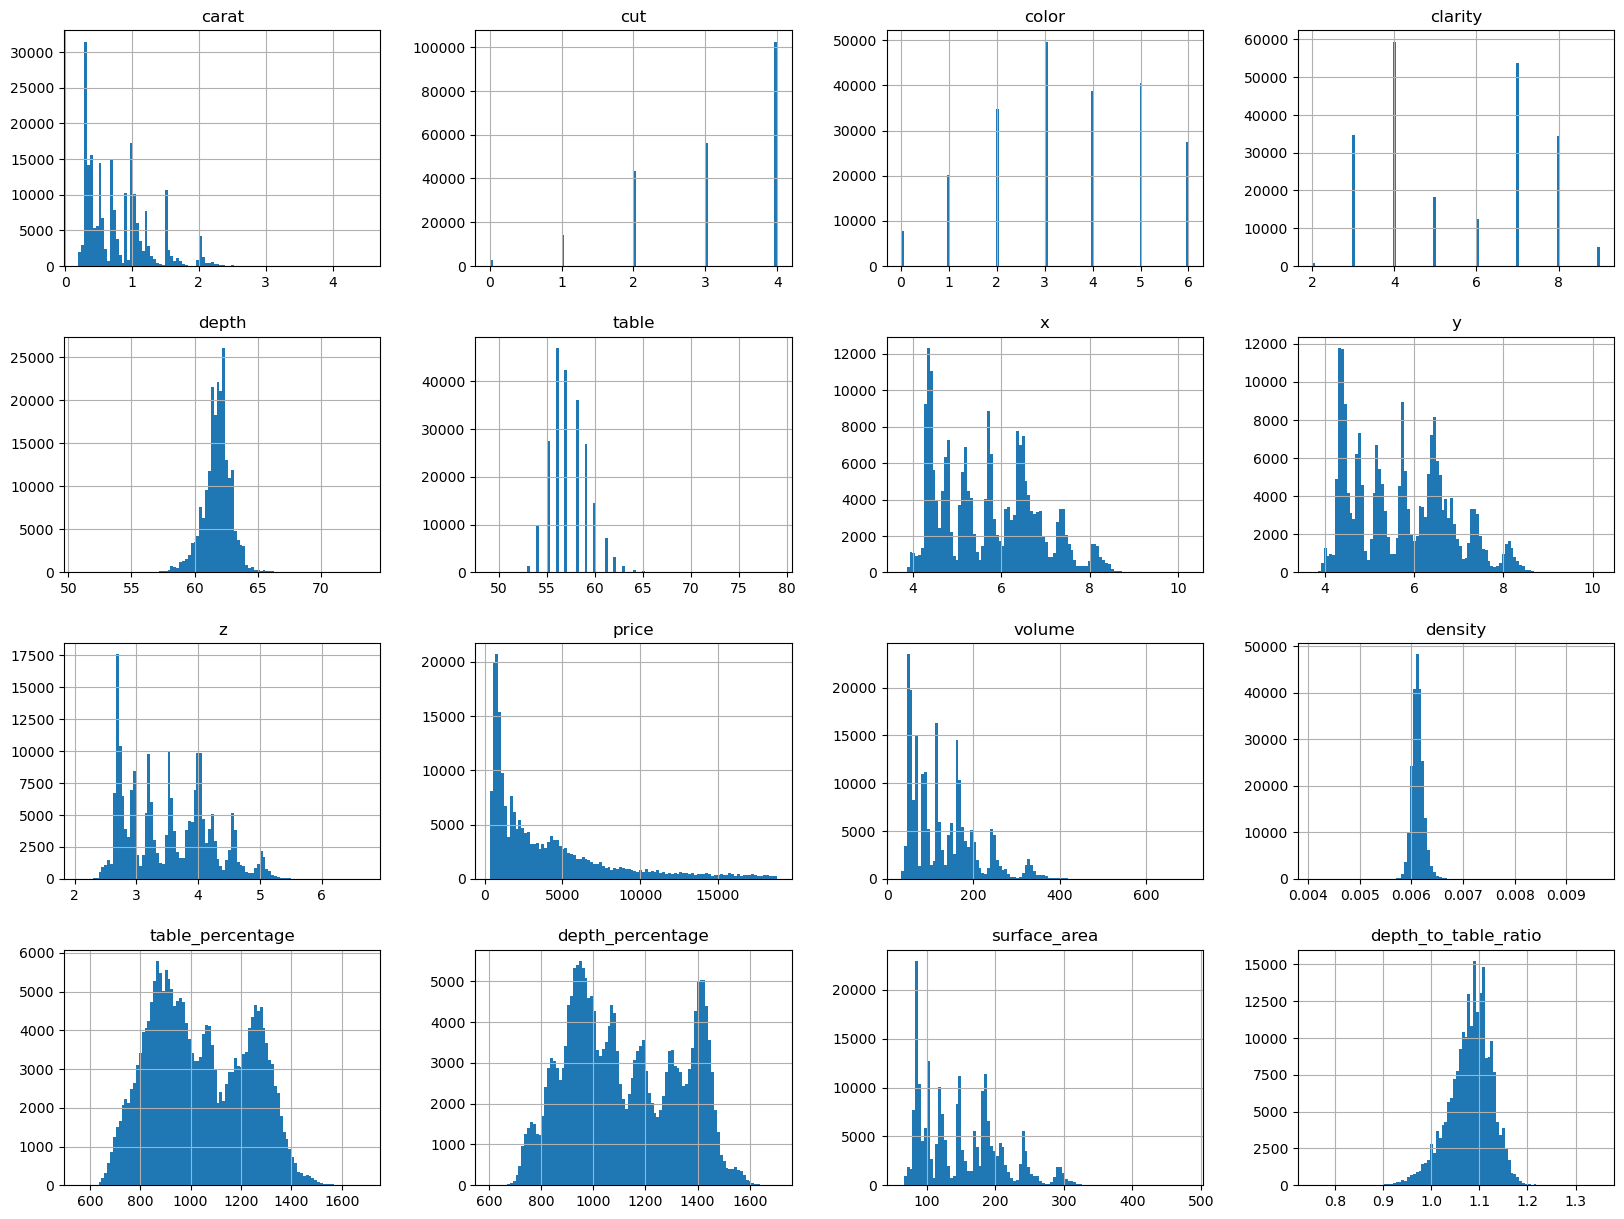

In [218]:
# Let's look at the data and lookf or outliers
train_df.hist(bins=100, figsize=(20, 15))
plt.show()

## Investigate the test data

In [219]:
# Load test data
test_df = pd.read_csv('./Data/test.csv')

# Preprocess test data to encode categorical features
test_df = preprocessing(test_df)

# get ids of test data where x or y, and z is 0
ids_x = test_df[(test_df['x'] == 0)]['id']
ids_y = test_df[(test_df['x'] == 0)]['id']
ids_z = test_df[(test_df['z'] == 0)]['id']

# check if ids x y and z are subset of each other
print(ids_x.isin(ids_y), len(ids_x), len(ids_y))
print(ids_x.isin(ids_z), len(ids_x), len(ids_z))
print(ids_y.isin(ids_z), len(ids_y), len(ids_z))


68406    True
74113    True
98515    True
Name: id, dtype: bool 3 3
68406    True
74113    True
98515    True
Name: id, dtype: bool 3 14
68406    True
74113    True
98515    True
Name: id, dtype: bool 3 14


So this tells us that all if if x is zero, then so to is y, and so is z. We want to now see if we can find similar data to impute the data.

Now we only have two values that depend on the dimensions which are the depth and the table, so we need to find the most similar values to impute them  

In [220]:
# Make a copy of test data which only includes columns depth and table
test_df_copy = test_df[['id', 'depth', 'table']].copy()

test_df_copy[['depth', 'table']]

,depth,table
0,62.3,56.0
1,62.8,56.0
2,61.9,53.0
3,61.6,55.0
4,62.7,56.0
...,...,...
129045,62.0,56.0
129046,59.6,62.0
129047,62.3,58.0
129048,62.0,56.0


In [221]:
pd.crosstab(train_df['clarity'], train_df['color']).style.background_gradient(cmap='YlOrRd')

color,0,1,2,3,4,5,6
clarity,,,,,,,
2,44,96,171,146,164,156,85
3,1333,2836,5897,5856,6309,6898,5688
4,2056,5825,10465,9567,10411,11609,9536
5,337,1365,2137,5926,3408,3349,1654
6,220,1098,2148,3952,2381,2072,498
7,2085,4668,7431,11912,9522,10868,7280
8,1645,3823,5512,10144,5562,5198,2665
9,107,413,903,2210,987,375,78


In [222]:
# Find most similar data to those with ids_x in test_data

for ix in ids_x.values:
    # Get the row and only keep the depth and table columns
    row = test_df[test_df['id'] == ix][['id', 'depth', 'table']]

    # Find the most similar data
    diff_df = test_df_copy[['depth', 'table']] - row[['depth', 'table']].values
    norm_df = diff_df.apply(lambda x: np.linalg.norm(x), axis=1)
    similar = test_df_copy.loc[norm_df.idxmin()]['id']

    # impute x and y of the similar data into the test data
    test_df.loc[test_df['id'] == ix, 'x'] = test_df[test_df['id'] == similar]['x'].values
    test_df.loc[test_df['id'] == ix, 'y'] = test_df[test_df['id'] == similar]['y'].values


# Now we can impute the z values
inds = test_df['z'][test_df['z']==0].index
test_df.loc[inds, 'z'] = test_df['depth'][inds] * (test_df['x'][inds] + test_df['y'][inds]) /200

/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_59477/3472792679.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(train_df['price']), bins=100)


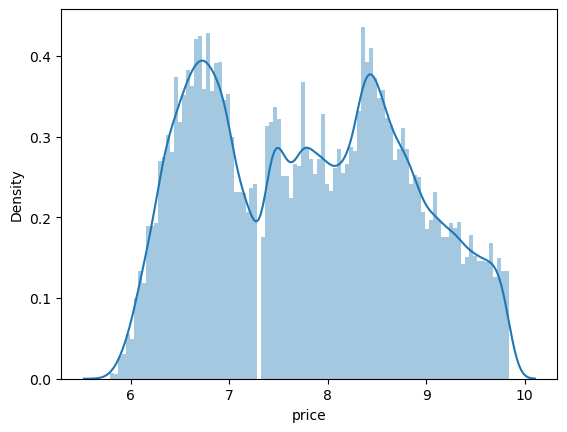

In [223]:
# Transforming to the log of price might improve the performance of the model
sns.distplot(np.log(train_df['price']), bins=100)
plt.show()

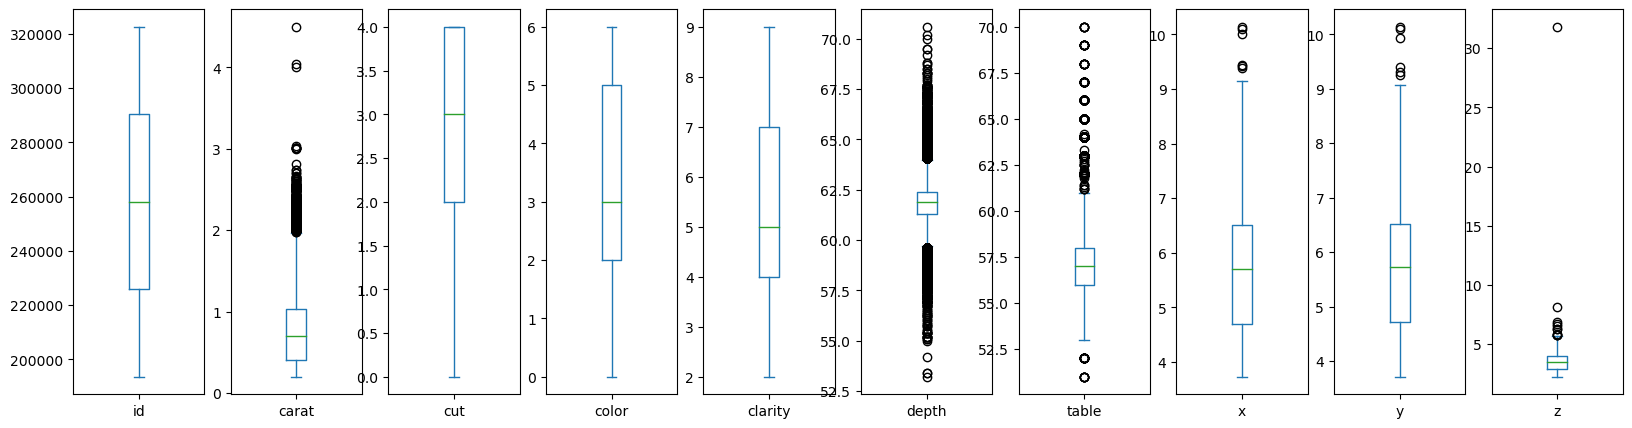

In [224]:
# Make box plot with quartiles and outliers of test data
test_df.plot.box(subplots=True, figsize=(20, 5))
plt.show()

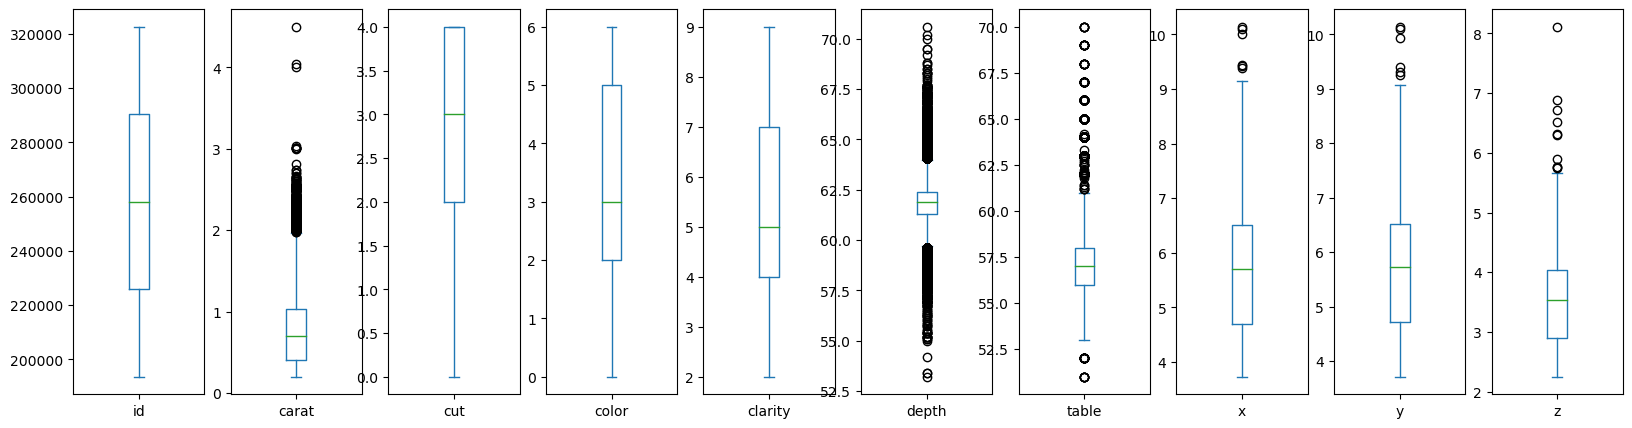

In [225]:
# So it looks like we have a lot of outliers in the test data in z, so we will replace it with the formula z = depth * (x + y) / 200
args = test_df['z'].idxmax()
test_df.loc[args, 'z'] = test_df.iloc[args]['depth'] * (test_df.iloc[args]['x'] + test_df.iloc[args]['y']) / 200

test_df.loc[args, 'z']

# Make box plot with quartiles and outliers of test data
test_df.plot.box(subplots=True, figsize=(20, 5))
plt.show()

carat                      Axes(0.125,0.11;0.0407895x0.77)
cut                     Axes(0.173947,0.11;0.0407895x0.77)
color                   Axes(0.222895,0.11;0.0407895x0.77)
clarity                 Axes(0.271842,0.11;0.0407895x0.77)
depth                   Axes(0.320789,0.11;0.0407895x0.77)
table                   Axes(0.369737,0.11;0.0407895x0.77)
x                       Axes(0.418684,0.11;0.0407895x0.77)
y                       Axes(0.467632,0.11;0.0407895x0.77)
z                       Axes(0.516579,0.11;0.0407895x0.77)
price                   Axes(0.565526,0.11;0.0407895x0.77)
volume                  Axes(0.614474,0.11;0.0407895x0.77)
density                 Axes(0.663421,0.11;0.0407895x0.77)
table_percentage        Axes(0.712368,0.11;0.0407895x0.77)
depth_percentage        Axes(0.761316,0.11;0.0407895x0.77)
surface_area            Axes(0.810263,0.11;0.0407895x0.77)
depth_to_table_ratio    Axes(0.859211,0.11;0.0407895x0.77)
dtype: object

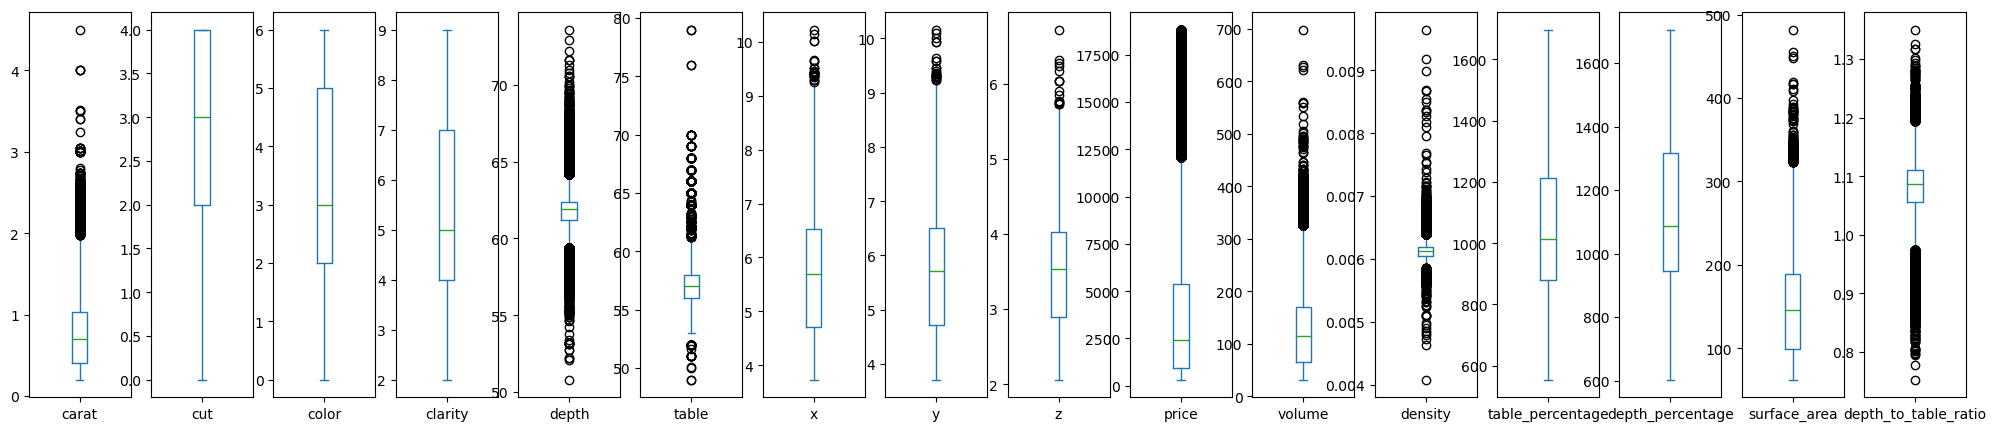

In [226]:
# Make similar box plot for training data
train_df.plot.box(subplots=True, figsize=(25, 5))

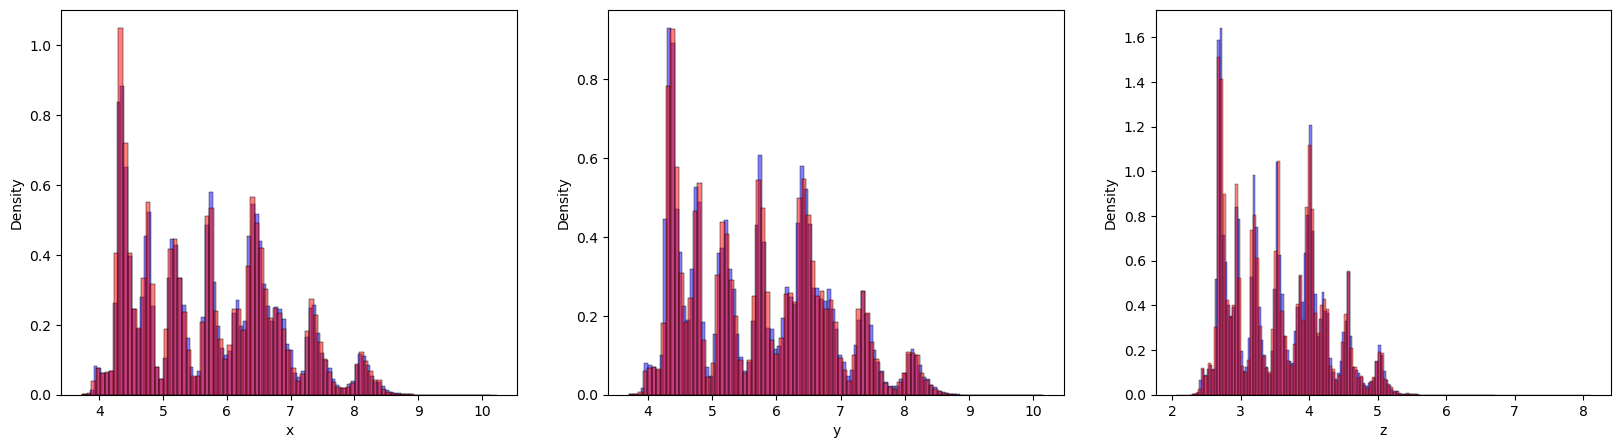

In [227]:
# Plot histogram of test data and train data on x, y, an z
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(train_df['x'], ax=ax[0], stat='density', color='blue', alpha=0.5)
sns.histplot(train_df['y'], ax=ax[1], stat='density', color='blue', alpha=0.5)
sns.histplot(train_df['z'], ax=ax[2], stat='density', color='blue', alpha=0.5)

sns.histplot(test_df['x'], ax=ax[0], stat='density', color='red', alpha=0.5)
sns.histplot(test_df['y'], ax=ax[1], stat='density', color='red', alpha=0.5)
sns.histplot(test_df['z'], ax=ax[2], stat='density', color='red', alpha=0.5)

plt.show()


<Axes: xlabel='carat', ylabel='Density'>

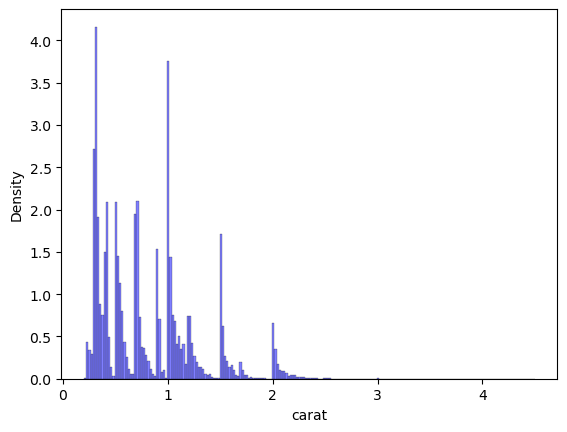

In [228]:
# Histogram of carat    
sns.histplot(train_df['carat'], stat='density', color='blue', alpha=0.5)

In [229]:
# Is the max carat in the training data an outlier?

train_df['carat'].describe()

count    219081.000000
mean          0.791503
std           0.464348
min           0.200000
25%           0.400000
50%           0.700000
75%           1.030000
max           4.500000
Name: carat, dtype: float64

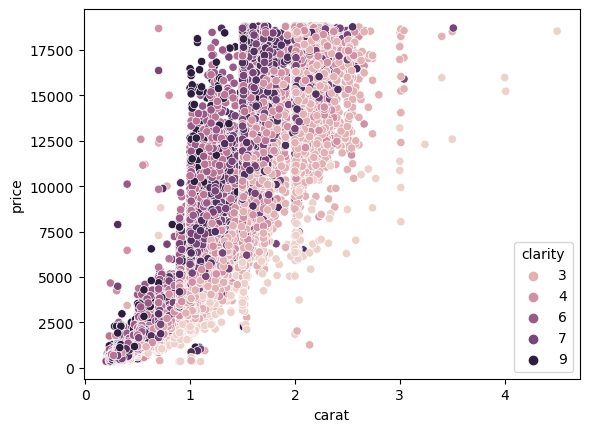

In [230]:
# So it looks like the max carat is an outlier, we can check this by plotting the price against carat with the hue set to clarity
sns.scatterplot(x='carat', 
                y='price', 
                hue='clarity', data=train_df)
plt.show()

So this doesn't look like an outlier since it has a high caret by low clarity which makes it valuable 

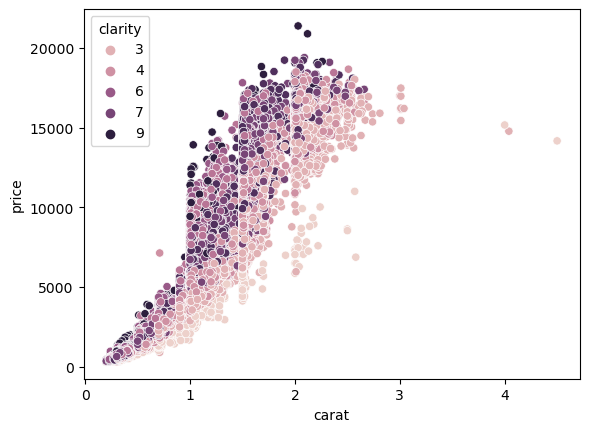

In [231]:
# Let's load in our most recent submission using xgboost and see if it also recreates a similiar plot
sub_df = pd.read_csv('./Data/submission_xgboost.csv')

# We need to join this with test_data on the id column 
sub_df = test_df.merge(sub_df, on='id')

sns.scatterplot(x='carat', 
                y='price', 
                hue='clarity', data=sub_df)

plt.show()


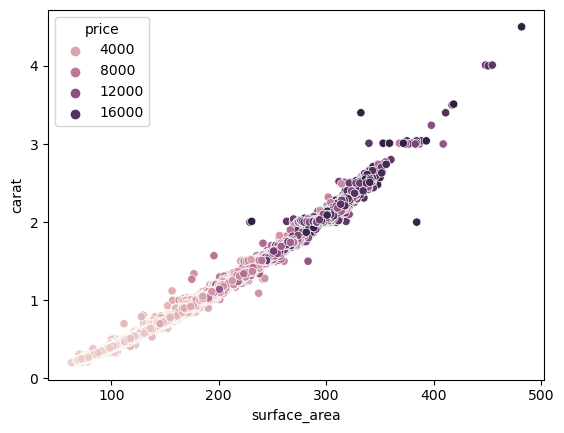

In [232]:
# Create a scatter plot of price vs surface area
sns.scatterplot(x='surface_area', y='carat', hue='price', data=train_df)

plt.show()